# Pre-process snmCATseq data for later use in sincei

This notebook uses a subset of data from the snmCAT-seq protocol presented in [Luo et. al (2022)](https://www.sciencedirect.com/science/article/pii/S2666979X22000271)


**NOTES**:
- unmeth is not a proper column naming, it actually corresponds to the total number of reads. It can be seen as the ratio of meth/unmeth maxes out at 0.5.

In [1]:
import os, tqdm, itertools, math
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_type = 'HCGN'

## 10k bin processing
Vivek has processed the data to create a 10k-binned dataset. We here import the single-sample sets and aggregate them into one dataset.
<br/>
<b>IMPORTANT:</b> Skip to the last part of this section for loading the bins, it these have already been saved
### Filter by bin coverage

In [5]:
def format_one_sample_depth(f, output_type='GCYN'):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    df = df['unmeth']
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

def format_one_sample_raw(f, output_type='GCYN'):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

In [7]:
bin_depth_df = Parallel(n_jobs=8, verbose=0)(
    delayed(format_one_sample_depth)(
        os.path.join('./snmC2Tseq_eckerlab/10k_bin/binned_10kb_all', f),
        output_type=data_type
    ) for f in tqdm.tqdm(os.listdir('./snmC2Tseq_eckerlab/10k_bin/binned_10kb_all'))
)
# formatted_df = pd.concat(dict(itertools.chain(*formatted_df)), axis=1)
bin_depth_df = pd.concat(dict(bin_depth_df), axis=1)
bin_depth_df = bin_depth_df.loc[
    [e for e in bin_depth_df.index if type(e) is str or not math.isnan(e)]
]


  4%|████████▎                                                                                                                                                                                              | 88/2107 [00:07<02:58, 11.31it/s]/Users/soufianemourragui/opt/miniconda3/envs/sincei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

  6%|███████████▎                                                                                                                                                                                          | 120/2107 [00:10<03:04, 10.75it/s]/Users/soufianemourragui/opt/miniconda3/envs/sincei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short

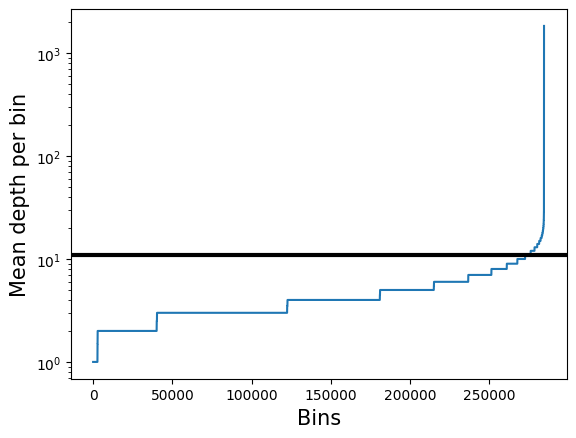

In [8]:
bin_depth_ranking_df = bin_depth_df.median(axis=1).sort_values()
plt.plot(bin_depth_ranking_df.values)
plt.axhline(bin_depth_ranking_df.tail(10000).values[0], linewidth=3, color='black')
plt.ylabel('Mean depth per bin', fontsize=15)
plt.xlabel('Bins', fontsize=15)
plt.yscale('log')

relevant_bins = bin_depth_ranking_df.tail(10000).index
relevant_bins = np.array(relevant_bins).astype(str)
relevant_bins = relevant_bins[relevant_bins != 'nan']

np.savetxt('./snmC2Tseq_eckerlab/10k_bin/top_bins_%s.txt'%(data_type), relevant_bins.astype(str), fmt='%s')

In [9]:
relevant_bins = np.loadtxt('./snmC2Tseq_eckerlab/10k_bin/top_bins_%s.txt'%(data_type), dtype=str)

### Import ratio

In [10]:
def format_one_sample_ratio(f, output_type='GCYN', relevant_bins=None):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    
    # Keep relevant bins
    if relevant_bins is not None:
        df = df.loc[np.intersect1d(df.index.astype(str), relevant_bins)]
    
    # Recompute ratio (not well computed in the tool, leading to a cap at 0.5).
    df['ratio'] = df['meth'] / df['unmeth']
    df = df['ratio']
    
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

def format_one_sample_raw(f, output_type='GCYN'):
    # output_type: GCYN or HCGN
    df = pd.read_csv(f, sep='\t').set_index('ctxt')
    df = df.loc[output_type].set_index('binID')
    df = df.loc[[e for e in df.index if type(e) is str]]
    return ((output_type, f), df)

In [11]:
formatted_df = Parallel(n_jobs=5, verbose=0)(
    delayed(format_one_sample_ratio)(
        os.path.join('./snmC2Tseq_eckerlab/10k_bin/binned_10kb_all', f), 
        relevant_bins=relevant_bins,
        output_type=data_type
    )
    for f in tqdm.tqdm(os.listdir('./snmC2Tseq_eckerlab/10k_bin/binned_10kb_all'))
)
# formatted_df = pd.concat(dict(itertools.chain(*formatted_df)), axis=1)
formatted_df = pd.concat(dict(formatted_df), axis=1)
formatted_df = formatted_df.loc[
    [e for e in formatted_df.index if type(e) is str or not math.isnan(e)]
]


  2%|████▋                                                                                                                                                                                                  | 50/2107 [00:09<05:23,  6.35it/s]/Users/soufianemourragui/opt/miniconda3/envs/sincei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/soufianemourragui/opt/miniconda3/envs/sincei/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

  3%|█████▏                                                                                                                                                                             

## Restrict ratio to deep enough bins

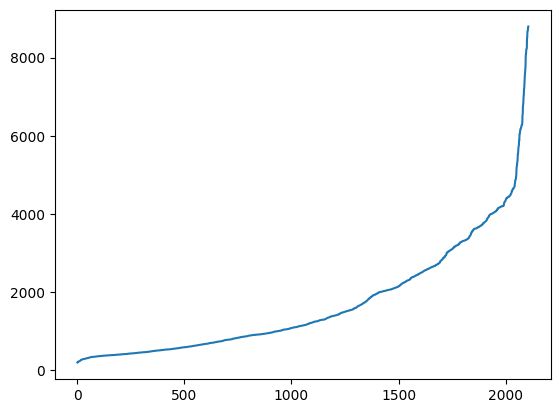

In [12]:
plt.plot(formatted_df.isna().sum(axis=0).sort_values().values)

filtered_formatted_df = formatted_df.loc[:,formatted_df.isna().sum(axis=0) < 4000]

In [13]:
# Mean imputation per row
filtered_formatted_df = filtered_formatted_df.fillna(filtered_formatted_df.mean(axis=0), axis=0)
filtered_formatted_df = filtered_formatted_df.T

In [14]:
filtered_formatted_df.to_pickle('./snmC2Tseq_eckerlab/10k_bin/processed_data_%s_2023_09_24.pkl'%(data_type))

In [15]:
filtered_formatted_df.to_csv('./snmC2Tseq_eckerlab/10k_bin/processed_data_%s_2023_09_24.csv.gz'%(data_type), compression='gzip')